In [5]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
import os
from scipy import interpolate


In [6]:
# Adapted RSC computation to deal with unknown sign convention anomaly on Aft antenna
def compute_radial_surface_current(level1, aux, gmf='mouche12'):
    dswasv = seastar.gmfs.doppler.compute_wasv(level1, aux, gmf)
    if level1.Antenna =='Aft':
        rsc = -level1.RadialSurfaceVelocity - dswasv
    else:
        rsc = level1.RadialSurfaceVelocity - dswasv
    return rsc

In [7]:
fig_folder='D:\\OneDrive - NERC\\OneDrive - NERC\\SEASTAR\\PM WP4000\\figures\\'
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# L1a to L1b processing

In [8]:
version = 'FINAL'
flight = '20220517'
file_paths = ss.utils.readers._set_file_paths()
oscar_path = os.path.join(file_paths['oscar_path'], version, flight, 'matlab-pre-processed','')
file_time_triplets = ss.oscar.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

DAR_tracks = ss.utils.readers._read_DAR_config(flight)
# L1a variables to be passed to L1b dataset
vars_to_keep = ['LatImage', 'LonImage', 'IncidenceAngleImage', 'LookDirection', 'SquintImage', 'CentralFreq']
ds_L1b = dict()
for track in DAR_tracks.keys():
    ds_ml = dict()
    file_index = DAR_tracks[track]
    ds_L1a = ss.oscar.tools.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    ds_L1a_dict_index = list(ds_L1a.keys())
    antenna_ident = ss.oscar.tools.identify_antenna_location_from_filename(
                        oscar_path,
                        file_time_triplets[file_index][1])
    print('Processing file index',file_index,'...')
    # L1b processing - loop through beams in L1a dataset dict
    #--------------------------------------------------------
    for dict_index in ds_L1a_dict_index:
        ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                 ds_L1a[dict_index],
                                 dummy_val=int(ds_L1a[dict_index].Dummy.data))
        ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                ds_L1a[dict_index],
                                window=7)
        ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
        ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
                                                    ds_L1a[dict_index],
                                                    antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
        ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
                                           ds_L1a[dict_index],
                                           options='from_SAR_time')
        ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
        ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
                                                         ds_ml[dict_index])
        
        ds_ml[dict_index].attrs['Title'] = ds_L1a[dict_index].Title
        ds_ml[dict_index]['TrackTime'] = ss.oscar.level1.track_title_to_datetime(ds_ml[dict_index].Title)
#-----------------------------------------------------------
    ds_ml = ss.oscar.level1.fill_missing_variables(ds_ml, antenna_ident)
# Build L1b dataset
    ds_L1b[track] = ss.oscar.level1.merge_beams(ds_ml, antenna_ident)
    del ds_ml 
print('...Done')

Device name = LIVPCSW-10
Setting local paths...
OSCAR L1 processing - version FINAL
-------------------
File path : D:\data\oscar\FINAL\20220517\matlab-pre-processed\
-------------------
File index : 0 , Aquisition time : 20220517T090013 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220517T090809 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220517T091519 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220517T093239 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220517T093818 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220517T094339 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220517T101737 , File list indices : [18, 19, 20]
Processing file index 3 ...
Processing file index 4 ...
Processing file index 5 ...
...Done


# L1b to L2 processing

In [9]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')
AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] =\
    xr.open_dataset(AROME_data_folder + file)

AROME_winds = xr.concat(list(AROME_dict.values()), dim='time', join='outer')
del AROME_dict
ds_L2 = dict()
sar_pixel_size=8
rolling_window_metres=200
rolling_window = int(round(rolling_window_metres/sar_pixel_size))
for track in ds_L1b.keys():
    print('Processing ' + track + '...')
    # Generating geophysical data fields for GMF doppler computation
    u10 = AROME_winds.u10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    v10 = AROME_winds.v10m.interp(time=ds_L1b[track].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1b[track].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b[track].longitude.median(), method='nearest')
    wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
    aux = ss.oscar.level1.init_auxiliary(ds_L1b[track].IncidenceAngleImage, wind_speed.data, wind_direction.data)
    # Compute RSC
    if flight == '20220517':
        rsc = [compute_radial_surface_current(ds_L1b[track].sel(Antenna=a),
                                              aux.sel(Antenna=a), gmf='mouche12') for a in antenna_ident]
    else:
        rsc = [ss.oscar.level1.compute_radial_surface_current(ds_L1b[track].sel(Antenna=a),
                                              aux.sel(Antenna=a), gmf='mouche12') for a in antenna_ident]
    ds_L1b[track]['RadialSurfaceCurrent'] = xr.concat(rsc, 'Antenna',join='outer')
    ds_L1b[track]['RadialSurfaceCurrent'] = ds_L1b[track].RadialSurfaceCurrent\
        .rolling(CrossRange=rolling_window, center=True).mean()\
        .rolling(GroundRange=rolling_window, center=True).mean()
    #L2 Processing
    # Initialise l2 dataset
    ds_L2[track] = ss.oscar.level1.init_level2(ds_L1b[track])
    # Compute current magnitude and direction
    ds_L2[track] = seastar.retrieval.level2.compute_current_magnitude_and_direction(ds_L1b[track], ds_L2[track])
    # Compute current vectors
    ds_L2[track]['CurrentVectorUComponent'], ds_L2[track]['CurrentVectorVComponent'] =\
    ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentVelocity'], ds_L2[track]['CurrentDirection'])
    #if list(ds_L2[track].dims.keys())[0] == 'GroundRange':
    #    ds_L2[track] = ds_L2[track][["CrossRange","GroundRange"]]
print('...Done')

Processing Track_1...
Processing Track_2...
Processing Track_1b...
...Done


# Load in and colocate Aux data

In [12]:
# ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(file_paths['xband_file'],
#                                                                    ds_L2[track][["CrossRange","GroundRange"]])
# ds_xband['CurrentVelocity'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
#     compute_Xband_current_magnitude_and_direction(ds_xband)

folder='unrestricted'
list22 = {}
list22['F1'] = 'MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc'
list22['L1'] = 'MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc'
list22['W3'] = 'WW3_NORGAS-UG_SEASTAREX_20220517.nc'
list22['HF_radial'] = 'HF_Brezellec_Radial_2022.nc'
list22['HF_0522'] = 'HF_combined_20220522.nc'

os.path.join(file_paths['aux_path'], folder, list22['L1'])
#F1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['F1'])
#L1 = xr.open_dataset(file_paths['aux_path'] + folder + list22['L1'])
#W3 = xr.open_dataset(file_paths['aux_path'] + folder + list22['W3'])
L1 = xr.open_dataset(os.path.join(file_paths['aux_path'], folder, list22['L1']))

cvel, cdir = ss.utils.tools.currentUV2VelDir(L1.U.data, L1.V.data)
L1['CurrentVelocity'] = (('time','nj','ni'), cvel)
L1['CurrentDirection'] = (('time','nj','ni'), cdir)
timesel = np.argmin(np.abs(L1.time.data - ds_L1b[track].sel(Antenna='Mid').TrackTime.data))
L1_CurrentMagnitude_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentVelocity.isel(time=timesel),
                                                                                 L1.latitude,
                                                                                 L1.longitude,
                                                                                 ds_L2[track][["CrossRange","GroundRange"]]
                                                                                )
L1_CurrentDirection_colocated = ss.retrieval.auxiliary.colocate_variable_lat_lon(L1.CurrentDirection.isel(time=timesel),
                                                                                 L1.latitude,
                                                                                 L1.longitude,
                                                                                 ds_L2[track][["CrossRange","GroundRange"]]
                                                                                )
# Load Auxiliary data
folder = 'unrestricted\\'
aux_file_list = os.listdir(file_paths['aux_path'] + folder)
MARS2D_files = [filename for filename in aux_file_list if 'MARS2D' in filename]
[filename for filename in MARS2D_files if '0522' in filename]
aux_list=dict()
for data_type in ['MARS2D', 'MARS3D','HF_combined', 'WW3']:
    aux_list[data_type] =xr.open_dataset(
        file_paths['aux_path'] + folder
        + ''.join([f for f in aux_file_list if data_type in f and '0522' in f])
                                        )
cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['MARS2D'].U.data, aux_list['MARS2D'].V.data)
aux_list['MARS2D']['CurrentMagnitude'] = (('time','nj','ni'), cvel)
aux_list['MARS2D']['CurrentDirection'] = (('time','nj','ni'), cdir)
aux_list['HF_combined'] = aux_list['HF_combined'].assign_coords(
        coords={'longitude': aux_list['HF_combined'].longitude, 'latitude': aux_list['HF_combined'].latitude})
cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['HF_combined'].U.data, aux_list['HF_combined'].V.data)
aux_list['HF_combined']['CurrentMagnitude'] = (('time','lat','lon'), cvel)
aux_list['HF_combined']['CurrentDirection'] = (('time','lat','lon'), cdir)
aux_list['HF_combined']['CurrentMagnitude'].assign_coords({'latitude':aux_list['HF_combined'].latitude,
                                                         'longitude':aux_list['HF_combined'].longitude})
aux_list['HF_radial'] = xr.open_dataset(file_paths['aux_path'] + folder
                            + 'HF_Brezellec_Radial_2022.nc')
aux_list['HF_radial'] = aux_list['HF_radial'].assign_coords({"latitude":(['lon', 'lat'], aux_list['HF_combined'].latitude.data),
                                     "longitude":(['lon', 'lat'], aux_list['HF_combined'].longitude.data)})
aux_list['HF_radial'] = aux_list['HF_radial'].drop_duplicates('time', keep='first')
#aux_list['Trefle_MLM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MLM.nc')
#aux_list['Trefle_MEM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MEM.nc')
#aux_list['Trefle_spectra'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_spectra.nc')
aux_list['Trefle'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg.nc')
aux_list['Trefle'] = aux_list['Trefle'].assign_coords(depth=("bin", aux_list['Trefle'].depth.data))
print('...Done')

...Done


In [10]:
aux_list['HF_radial']

<xarray.Dataset>
Dimensions:    (time: 12628, lon: 110, lat: 80)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-27T08:00:00 ... 2022-10-03T11:07:44
    latitude   (lon, lat) float32 47.3 47.3 47.3 47.3 ... 49.27 49.27 49.27
    longitude  (lon, lat) float32 -6.783 -6.756 -6.729 ... -4.701 -4.674 -4.647
Dimensions without coordinates: lon, lat
Data variables:
    dN         (lat, lon) float32 ...
    dE         (lat, lon) float32 ...
    U          (time, lat, lon) float32 ...
    Us         (time, lat, lon) float32 ...
Attributes:
    Site_latitude:   48.0688872085959
    Site_longitude:  -4.6666665593692

In [ ]:
coords_list = [
    'IncidenceAngleImage',
]
vars_list = [
    'CurrentMagnitude',
    'CurrentDirection',
    'CurrentVectorUComponent',
    'CurrentVectorVComponent',
]
all_star_tracks_list = ['Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18']
all_track_list = [11, 12, 13, 14, 15, 16, 17, 18]
dsl2 = [None] * len(all_star_tracks_list)
for ii, track in enumerate(all_star_tracks_list):

    dsl2[ii] = ds_L2[track][coords_list + vars_list]
    dsl2[ii]['AntennaAzimuthImage'] = ds_L1b[track].AntennaAzimuthImage
#      = ds.set_coords(coords_list)

L2 = xr.concat(dsl2, dim='Track')
L2['Track'] = all_track_list

In [ ]:
L2.CurrentMagnitude\
    .plot(col='Track',
          x='CrossRange', y='GroundRange',
          vmin=0, vmax=1,
          col_wrap=4)

In [ ]:
plot_pixel_size = 100 #pixel size in metres
sar_pixel_size = 8
c_factor = int(plot_pixel_size / sar_pixel_size)

HF_effective_depth = sp.constants.c * (1 / 7.8e06) / (8 * np.pi) # 7.8MHz HF frequency

lon=aux_list['Trefle'].longitude.mean().data
lat=aux_list['Trefle'].latitude.mean().data
U_oscar=np.empty(0)
U_adcp=np.empty(0)
U_HF=np.empty(0)
tracks=[];
for i in range(11,18 + 1):
    track = 'Track_' + str(i)
    tracks.append(track)
# First, find the index of the grid point nearest a specific lat/lon.
    abslat = np.abs(ds_L2[track].latitude-lat)
    abslon = np.abs(ds_L2[track].longitude-lon)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    
    U_oscar = np.append(U_oscar,
                        ds_L2[track].CurrentMagnitude\
                        .coarsen(GroundRange=c_factor,boundary='trim').mean()\
                        .coarsen(CrossRange=c_factor,boundary='trim').mean()\
                        .sel(CrossRange=ds_L2[track].CrossRange[xloc],
                                  GroundRange=ds_L2[track].GroundRange[yloc],
                            method='nearest'))
    t = ds_L2[track].TrackTime
    U_adcp = np.append(U_adcp,
                       np.sqrt(aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0) ** 2\
                               + aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0) ** 2
                              )
                      )
    abslat = np.abs(aux_list['HF_combined'].latitude-lat)
    abslon = np.abs(aux_list['HF_combined'].longitude-lon)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    U_HF = np.append(U_HF, aux_list['HF_combined'].CurrentMagnitude.isel(lat=yloc,lon=xloc)\
                       .sel(time=t, method='nearest')
                    )
    
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
plt.scatter(U_adcp, U_oscar,label='OSCAR')
plt.scatter(U_adcp, U_HF,label='HF Radar')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'k')
plt.xlabel('ADCP 3m velocity (m/s)', fontsize=20)
plt.ylabel('Retrieved current velocity (m/s)', fontsize=20)
plt.legend()
plt.show()

In [ ]:
u10.plot()

In [ ]:
ds_L2['Track_12'].CurrentMagnitude\
                 .coarsen(GroundRange=c_factor,boundary='trim').mean()\
                 .coarsen(CrossRange=c_factor,boundary='trim').mean()\
                 .plot(x='longitude',
                       y='latitude',
                       vmin=0, vmax=1)
plt.scatter(lon,lat)


In [ ]:
quivers=False

for track in ds_L2.keys():
    tracktime = str(np.datetime64(ds_L2[track].TrackTime.data,'m'))
    # Plot current magnitude with u,v vectors overlain, geographic coordinates
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor_image = int(plot_pixel_size / sar_pixel_size)
    #c_factor = 1 # Coarsening factor
    q_factor = 30 # Quiver plot scaling factor
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    im=ds_L2[track]\
    .coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
    .coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
    .CurrentMagnitude.plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    if quivers:
        ds_L2[track]\
        .coarsen(GroundRange=q_factor,boundary='trim').mean()\
        .coarsen(CrossRange=q_factor,boundary='trim').mean()\
        .plot.quiver(
            x='longitude',
            y='latitude',
            u='CurrentVectorUComponent',
            v='CurrentVectorVComponent',
            scale=50,
            angles='xy',
            robust=True,
            transform=ccrs.PlateCarree()
        )
        
    #plt.title(ds_L1b[track].attrs['Title'])
    gl=ax.gridlines(draw_labels=False)
    gl.top_labels=False
    gl.right_labels=False
    
    gl.bottom_labels=False
    gl.left_labels=False
    
    #ax.set_extent([-5.2, -5.025, 48.37, 48.5], crs=ccrs.PlateCarree())
    #with warnings.catch_warnings():
    #    warnings.simplefilter("ignore", category=Warning)
    #ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    
    #cbar = plt.colorbar(im)
    #cbar.set_label('RSC velocity (m/s)',fontsize=30)
    
    #plt.plot((-5.13305, 48.4166), marker="^", color='r', markersize=2)
    #plt.show()
    
    SMALL_SIZE = 20
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [ ]:
Trefle = xr.open_dataset(local_paths['aux_path'] + folder + 'Trefle_MLM.nc')
GL1 = xr.open_dataset(local_paths['aux_path'] + folder + 'GL_TS_MO_6200001.nc')

In [ ]:
for t in ds_comparison.time.data:
    HFCurrentMagnitude = aux_list['HF_combined'].CurrentMagnitude.sel(time=t, method='nearest')
    ds_comparison = xr.concat([ds_comparison, HFCurrentMagnitude], dim='time', join='outer')

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im = aux_list['HF_combined'].CurrentMagnitude\
                            .sel(time=ds_L2[track].TrackTime,method='nearest')\
                            .plot(x='longitude',y='latitude',
                            robust=True, 
                            #cmap='coolwarm',
                            #vmin=0, vmax=3,
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False,
                                 )
#ax.set_extent([-5.7, -4, 47.5, 48.7], crs=ccrs.PlateCarree())
ax.set_extent([-5.25, -4.95, 48.2, 48.6], crs=ccrs.PlateCarree())
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=Warning)
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
cbar = plt.colorbar(im)
cbar.set_label('Current velocity (m/s)',fontsize=30)
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
ds_L2['Track_1']

<xarray.Dataset>
Dimensions:                  (GroundRange: 413, CrossRange: 3148)
Coordinates:
  * GroundRange              (GroundRange) float64 528.0 536.0 ... 3.824e+03
  * CrossRange               (CrossRange) float64 -1.254e+04 ... 1.264e+04
    latitude                 (CrossRange, GroundRange) float64 48.33 ... 48.55
    longitude                (CrossRange, GroundRange) float64 -5.103 ... -5.157
Data variables:
    CurrentVelocity          (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentDirection         (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentVectorUComponent  (CrossRange, GroundRange) float64 nan nan ... nan
    CurrentVectorVComponent  (CrossRange, GroundRange) float64 nan nan ... nan

# Solve HF Brezellec radials

C:\Users\dmca\Anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\dmca\Anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\dmca\Anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


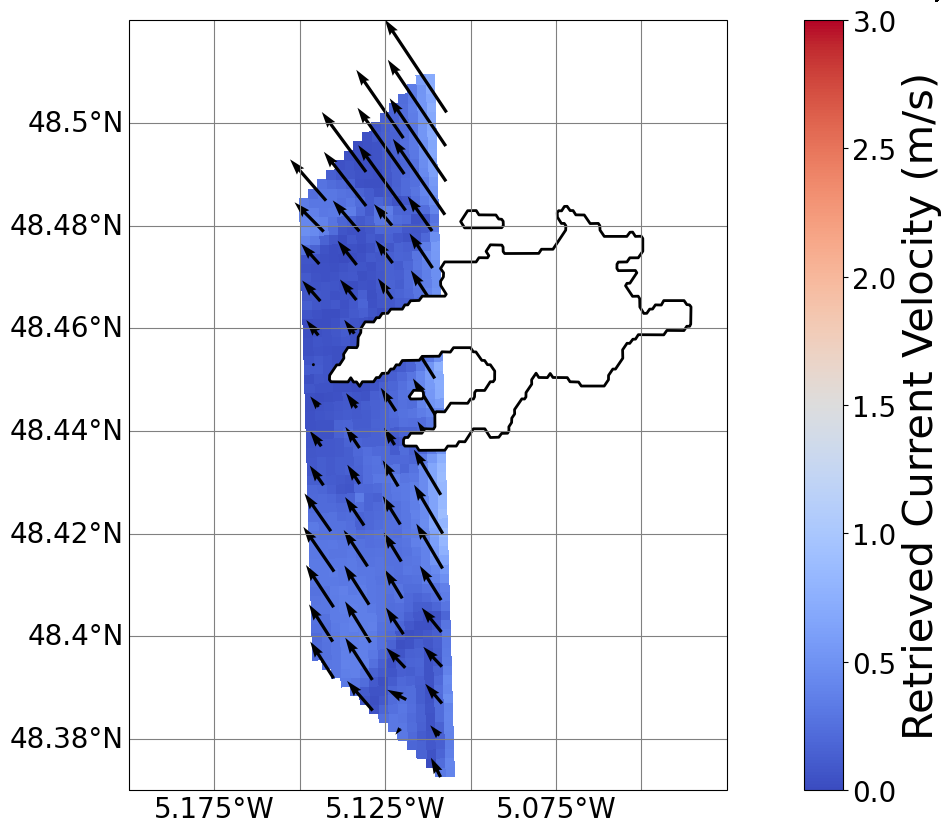

In [126]:
dlat = aux_list['HF_radial'].Site_latitude - ds_L2['Track_1'].latitude
dlon = aux_list['HF_radial'].Site_longitude - ds_L2['Track_1'].longitude
dist = np.sqrt(dlon **2 + dlat **2)
unit_lon = dlon / dist
unit_lat = dlat / dist
unit_radials['U_corrected'] = unit_lon * ds_L2['Track_1'].CurrentVectorUComponent + unit_lat * ds_L2['Track_1'].CurrentVectorVComponent
unit_radials['V_corrected'] = unit_lat * ds_L2['Track_1'].CurrentVectorUComponent + unit_lon * ds_L2['Track_1'].CurrentVectorVComponent
# lat = aux_list['HF_radial'].Site_latitude
# lon = aux_list['HF_radial'].Site_longitude
# unit_vector = [np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)]
# dot_product = (ds_L2['Track_1'].CurrentVectorUComponent * unit_vector[0]
#               +ds_L2['Track_1'].CurrentVectorVComponent * unit_vector[1])

# unit_radials=xr.Dataset()
# unit_radials['U_corrected'] = dot_product * unit_vector[0]
# unit_radials['V_corrected'] = dot_product * unit_vector[1]
unit_radials['cdir'] = np.sqrt(unit_radials.U_corrected **2 + unit_radials.V_corrected **2)


# cvel, cdir = ss.utils.tools.currentUV2VelDir(unit_radials.U_corrected, unit_radials.V_corrected)
# unit_radials['cvel'] = cvel
# unit_radials['cdir'] = xr.DataArray(data=cdir, coords=cvel.coords, dims=cvel.dims)


track='Track_1'
tracktime = str(np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m'))
plot_pixel_size = 200 #pixel size in metres
sar_pixel_size = 8
c_factor_image = int(plot_pixel_size / sar_pixel_size)
q_factor = 100 # Quiver plot scaling factor
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator(), frameon=True)
im=unit_radials\
.coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
.coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
.cvel\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
unit_radials\
.coarsen(GroundRange=q_factor,boundary='trim').mean()\
.coarsen(CrossRange=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='U_corrected',
    v='V_corrected',
    scale=20,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
gl=ax.gridlines(draw_labels=True, color='gray')
gl.top_labels=False
gl.right_labels=False
ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
cbar = plt.colorbar(im)
cbar.set_label('Retrieved Current Velocity (m/s)',fontsize=30)
plt.scatter(aux_list['HF_radial'].Site_longitude,
           aux_list['HF_radial'].Site_latitude,
           transform=ccrs.PlateCarree())

# q_factor = 200 
# unit_radials\
# .coarsen(GroundRange=q_factor,boundary='trim').mean()\
# .coarsen(CrossRange=q_factor,boundary='trim').mean()\
# .plot.quiver(x='longitude', y='latitude', u='U', v='V', scale=10, angles='xy', robust=True)
# plt.scatter(aux_list['HF_radial'].Site_longitude, aux_list['HF_radial'].Site_latitude)

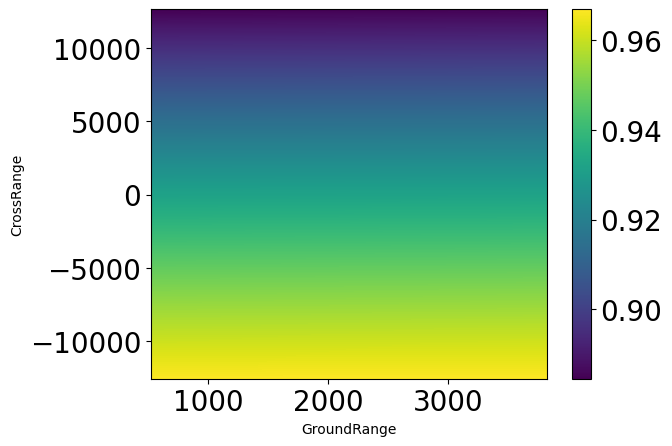

In [101]:
lat = aux_list['HF_radial'].Site_latitude - ds_L2['Track_1'].latitude
lon = aux_list['HF_radial'].Site_longitude - ds_L2['Track_1'].longitude
unit_vector = [np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)]
dot_product = (ds_L2['Track_1'].CurrentVectorUComponent * unit_vector[0]
              +ds_L2['Track_1'].CurrentVectorVComponent * unit_vector[1])
U_corrected = dot_product * unit_vector[0]
V_corrected = dot_product * unit_vector[1]

np.sqrt(unit_vector[0] **2 + unit_vector[1] **2).plot()

In [149]:
np.argmin(np.abs(aux_list['HF_radial'].time.data - tracktime))

2446

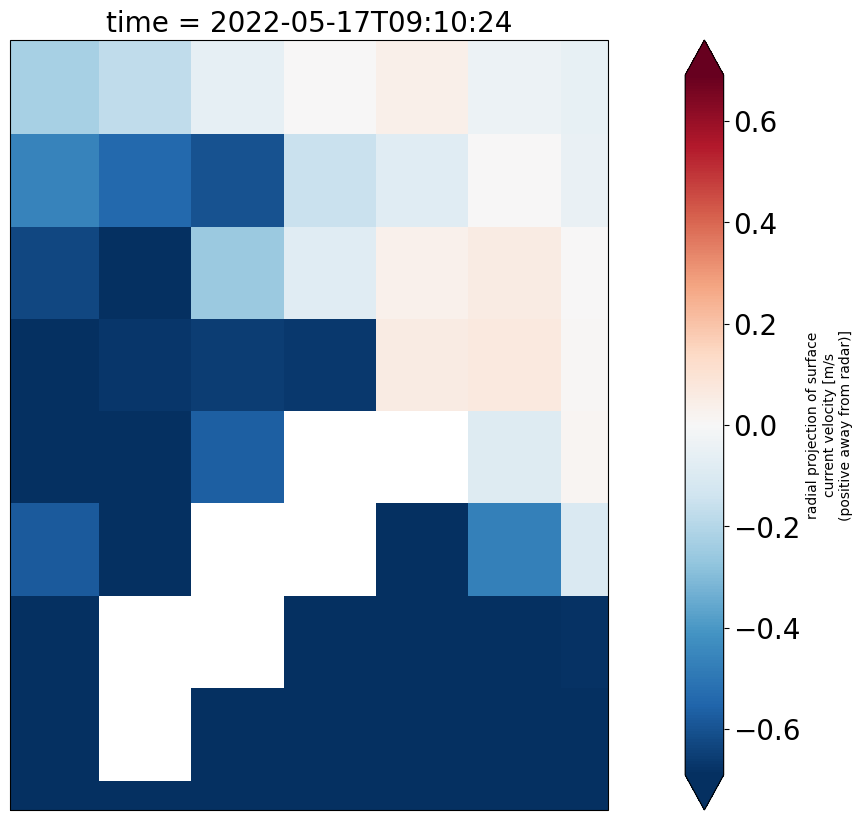

In [152]:
tracktime = np.datetime64(ds_L1b[track].sel(Antenna='Mid').TrackTime.data,'m')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im = aux_list['HF_radial'].U\
                            .isel(time=np.argmin(np.abs(aux_list['HF_radial'].time.data - tracktime)))\
                            .plot(x='longitude',y='latitude',
                            robust=True, 
                            #cmap='coolwarm',
                            #vmin=0, vmax=3,
                            transform=ccrs.PlateCarree(),
                            add_colorbar=True,
                                 )
ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree())

In [ ]:
latitude, longitude = np.meshgrid(aux_list['HF_combined'].latitude.data, aux_list['HF_combined'].longitude.data)
aux_list['HF_combined'].latitude

In [ ]:

aux_list['HF_radial'].isel(
    time=np.argmin(np.abs(aux_list['HF_radial'].time - ds_L2[track].TrackTime),keepdims=True).data
).U.plot(x='longitude',y='latitude')




In [ ]:
ds_comparison

In [ ]:
np.sqrt(aux_list['Trefle'].v_e.sel(time=ds_L2[track].TrackTime,method='nearest').isel(bin=0).data ** 2
 + aux_list['Trefle'].v_n.sel(time=ds_L2[track].TrackTime,method='nearest').isel(bin=0).data ** 2)

In [ ]:
mask = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1b[track].Interferogram.sel(Antenna='Mid'),
                                                        skip=1/1000)
mask.plot(x='CrossRange',y='GroundRange')